<h2> Problem Statement </h2>

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

https://www.kaggle.com/imakash3011/customer-personality-analysis

Tasks:

1. Build a unsupervised algorithm to cluster customer data (recommended: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) . Write a short text of what is the key business takeaway of the recommendation.
	Points: 4

2. Build a classification model (binomial or multinomial - recommended: xgboost python implementation) on the promotion done by the company. Run SHAP analysis on the model results, and write a short text of what would be your recommendation to business for the next round of campaigns.
	Points: 6

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GITHUB/Internship/marketing_campaign.csv",sep="\t")

In [71]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [135]:
df["Response"].value_counts()

0    1879
1     333
Name: Response, dtype: int64

In [72]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2240, 29)


In [73]:
#finding the different types of data and if there are any null values
df.info()
# we can see that the Income column has some null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [74]:
# removing the rows with null values and pring the shape
df = df.dropna()
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2216, 29)


In [75]:
# Dt_Customer is categorical but it has the useful information of date on which the customer joined. so lets convert it to datetime format.
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
joining_date = []
for i in df["Dt_Customer"]:
    i = i.date()
    joining_date.append(i)  

print("The latest customer's joining date:",max(joining_date))
print("The first customer's joining date:",min(joining_date))

The latest customer's joining date: 2014-12-06
The first customer's joining date: 2012-01-08


In [76]:
#finding out the number of days since the customer joined

count = []
x = max(joining_date) #taking it to be the newest customer
for i in joining_date:
    y = x - i
    count.append(y)
df["numberof_days"] = count
df["numberof_days"] = pd.to_numeric(df["numberof_days"], errors="coerce")

In [77]:
print("Number of categories for Marital_Status column:\n", df["Marital_Status"].value_counts())
print("Number of categories for Education column:\n", df["Education"].value_counts())

Number of categories for Marital_Status column:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
Number of categories for Education column:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [78]:
#Creating new features

#Combining all the spendings for each customer in last 2 years
df["total_expense"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Calculating the age
df["years_old"] = 2021-df["Year_Birth"]

#number of children  
df["children"]=df["Teenhome"] + df["Kidhome"]

#using the marital status column
df["Marital_Statusnew"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#household size
df["household_size"] = df["Marital_Statusnew"].replace({"Alone": 1, "Partner":2})+ df["children"]


In [79]:

#Is the person parent or not
df["parent_ornot"] = np.where(df["children"]> 0, 1, 0)

#Removing features which are not useful
df = df.drop(["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"], axis=1)

#better organizing the education column
df["Education"]=df["Education"].replace({"Basic":"school","2n Cycle":"school", "Graduation":"undergraduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


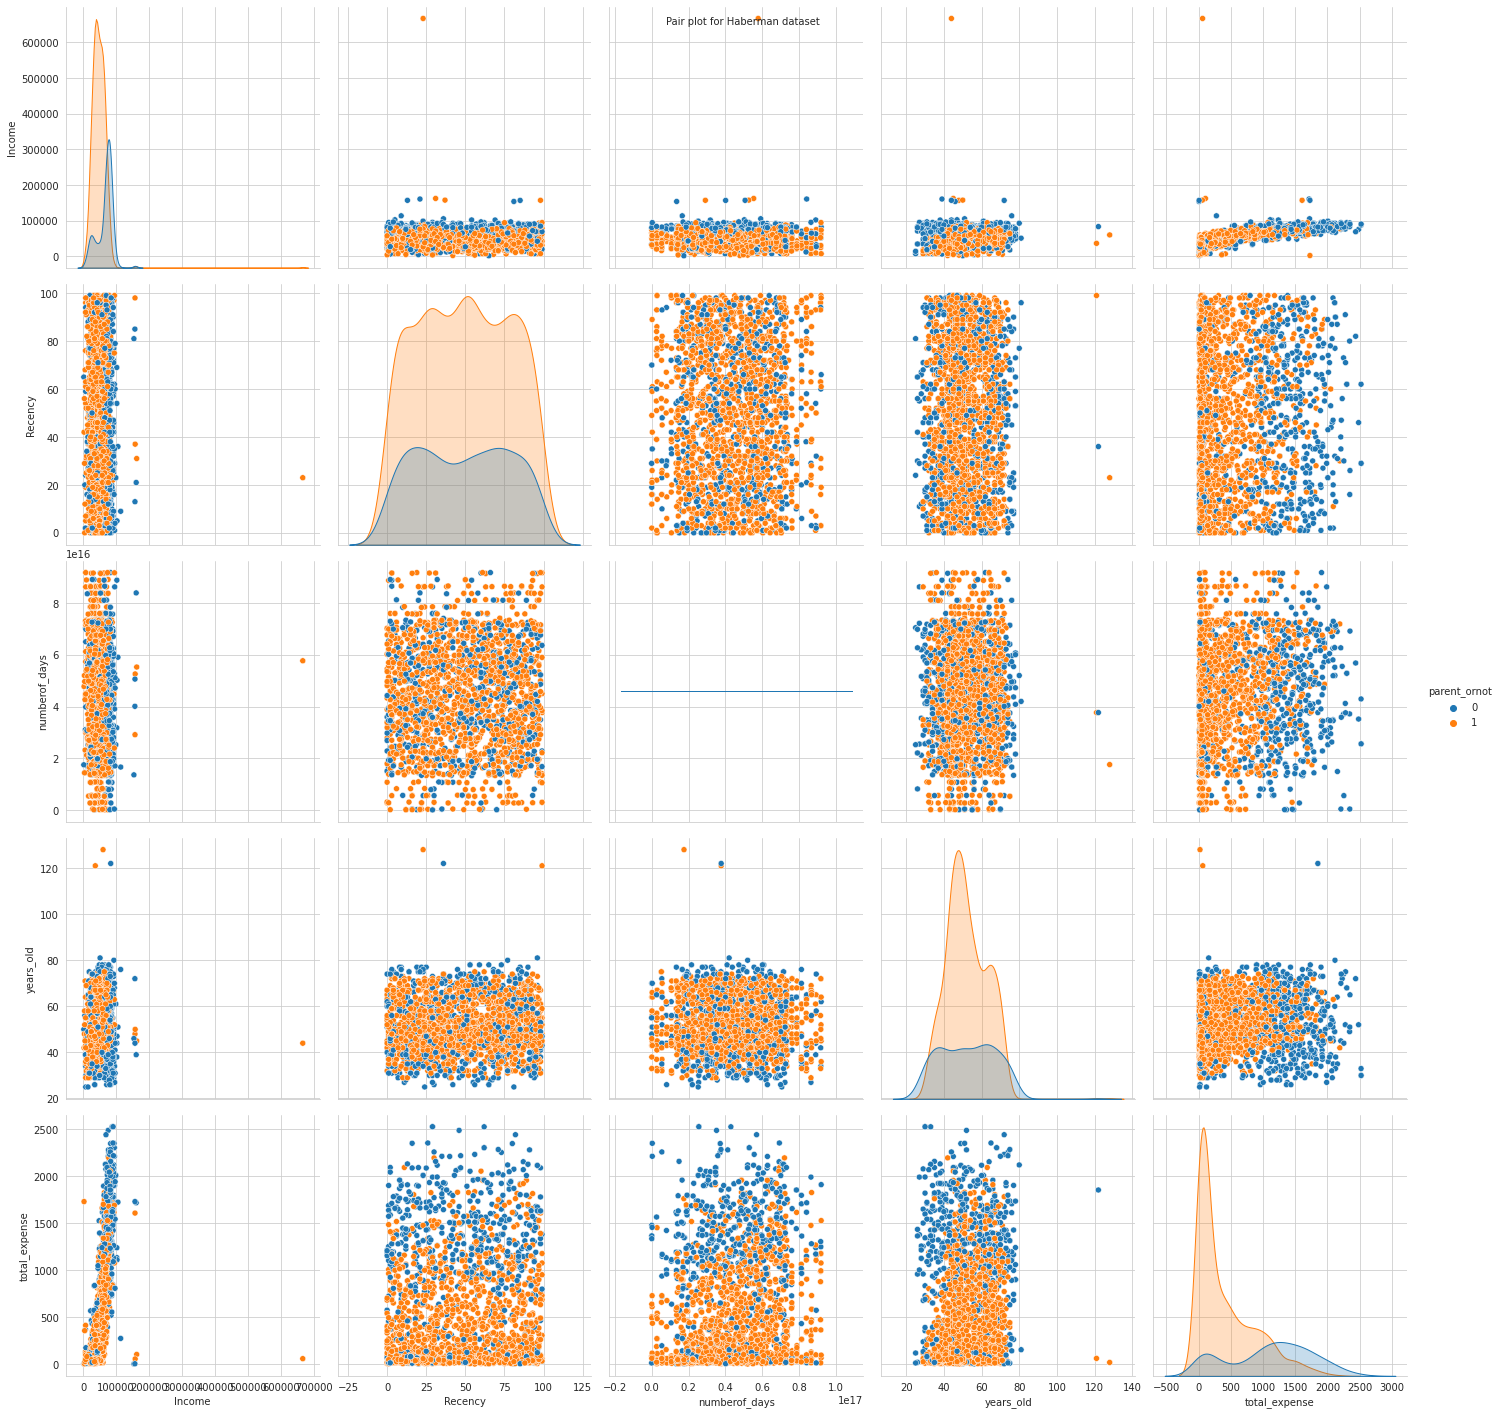

In [85]:
# pair plots sometime helps in finding outliers

sns.set_style("whitegrid")
sns.pairplot(df, hue="parent_ornot",size=4,vars=[ "Income", "Recency", "numberof_days", "years_old", "total_expense"])
plt.suptitle('Pair plot for Haberman dataset',size=10)
plt.show()

In [91]:
#few outliers are present which needs to be removed
df = df[(df["years_old"]<100)]
df = df[(df["Income"]<500000)]
print("final shape of the dataset", df.shape)

final shape of the dataset (2212, 30)


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   MntWines             2212 non-null   int64  
 6   MntFruits            2212 non-null   int64  
 7   MntMeatProducts      2212 non-null   int64  
 8   MntFishProducts      2212 non-null   int64  
 9   MntSweetProducts     2212 non-null   int64  
 10  MntGoldProds         2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   i

In [94]:
z = pd.get_dummies(df["Education"])

In [96]:
p =  pd.get_dummies(df["Marital_Statusnew"])

In [121]:
final = pd.concat([df,z,p], axis=1)

In [122]:
final.drop(['Education','Marital_Statusnew','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'], axis=1, inplace=True)


In [123]:
column_list = final.columns

In [126]:
final

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,numberof_days,total_expense,years_old,children,household_size,parent_ornot,Postgraduate,school,undergraduate,Alone,Partner
0,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.676245,1.018352,-1.264598,-1.758359,-1.581139,-0.786220,-0.358569,0.991895,1.349603,-1.349603
1,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,-0.963297,1.274785,1.404572,0.449070,0.632456,-0.786220,-0.358569,0.991895,1.349603,-1.349603
2,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.280110,0.334530,-1.264598,-0.654644,-1.581139,-0.786220,-0.358569,0.991895,-0.740959,0.740959
3,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-0.920135,-1.289547,0.069987,0.449070,0.632456,-0.786220,-0.358569,0.991895,-0.740959,0.740959
4,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-0.307562,-1.033114,0.069987,0.449070,0.632456,1.271909,-0.358569,-1.008171,-0.740959,0.740959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.430444,-0.822754,0.908097,-0.104347,1.197084,0.419540,0.066770,0.079461,2.213965,3.928291,-0.168701,1.791619,0.111982,-0.555814,-0.132545,0.124112,1.218061,0.163575,0.069987,0.449070,0.632456,-0.786220,-0.358569,0.991895,-0.740959,0.740959
2208,0.560123,2.902796,0.908097,0.241237,0.298631,-0.662628,-0.611184,-0.687527,-0.658360,-0.694954,2.429954,1.426865,-0.229679,-0.248141,0.692181,-1.940414,-0.271040,1.958607,2.739158,2.656499,0.632456,1.271909,-0.358569,-1.008171,-0.740959,0.740959
2209,0.233347,-0.822754,-0.929699,1.450778,1.787156,0.545373,0.222878,-0.103155,-0.366260,-0.385448,-0.688432,-0.761665,0.111982,2.213242,0.279818,-0.847936,1.052052,-1.033114,-1.264598,-1.758359,-1.581139,-0.786220,-0.358569,0.991895,1.349603,-1.349603
2210,0.803172,-0.822754,0.908097,-1.417564,0.363866,0.092373,0.209498,0.773403,0.071892,0.330284,-0.168701,0.697355,0.795303,1.290224,-0.957271,-0.843635,0.391336,1.103830,0.069987,0.449070,0.632456,1.271909,-0.358569,-1.008171,-0.740959,0.740959


In [124]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
final = scaler.fit_transform(final)

In [125]:
final = pd.DataFrame(final,columns= column_list )


##kmeans clustering

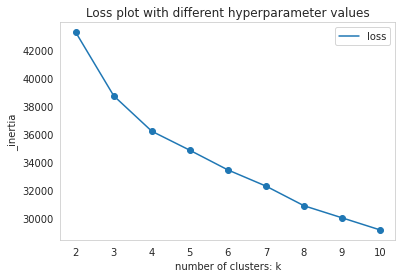

In [127]:

from sklearn.cluster import KMeans

k=[2,3,4,5,6,7,8,9,10]
loss=[]
for i in k:
  kmeans = KMeans(n_clusters=i, random_state=0).fit(final)
  loss.append(kmeans.inertia_)

plt.plot(k, loss, label='loss')
plt.scatter(k, loss)
plt.legend()
plt.xlabel("number of clusters: k")
plt.ylabel("_inertia")
plt.title("Loss plot with different hyperparameter values")
plt.grid()
plt.show()

In [128]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(final)

In [129]:
predicted=kmeans.predict(final)

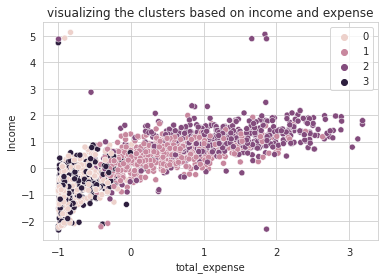

In [143]:

pl = sns.scatterplot(data = final,x=final["total_expense"], y=final["Income"],hue=predicted)
pl.set_title("visualizing the clusters based on income and expense")
plt.legend()
plt.show()

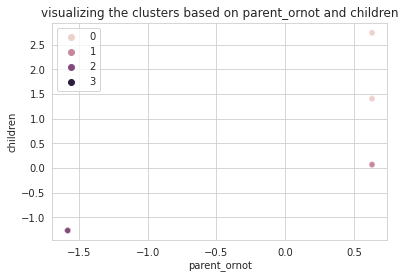

In [145]:

pl = sns.scatterplot(data = final,x=final["parent_ornot"], y=final["children"],hue=predicted)
pl.set_title("visualizing the clusters based on parent_ornot and children")
plt.legend()
plt.show()

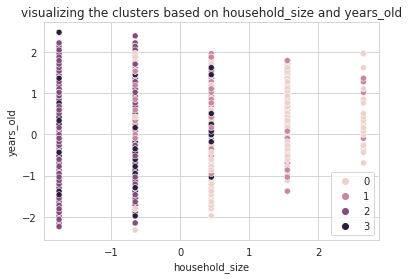

In [146]:
pl = sns.scatterplot(data = final,x=final["household_size"], y=final["years_old"],hue=predicted)
pl.set_title("visualizing the clusters based on household_size and years_old")
plt.legend()
plt.show()

##Observations

Every cluster has it's own properties
1. For cluster 3, smaller household size, wide range of age groups, not a parent, income and total expense is less.

2. for cluster 0, larger houselhold size, average age group, are a parent, income and total expense is less to medium.

3. for cluster 1, 

so based on cluster properties we can send specific product offers.


##Xgboost binary classification

In [138]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


x_model=XGBClassifier()

prams={    
     'n_estimators': [70, 90, 100, 150],
     'max_depth': [5, 6, 7, 8],
}
random_m=RandomizedSearchCV(x_model,param_distributions=prams,verbose=10,n_jobs=-1)
random_m.fit(final, df['Response'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.1s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [139]:
random_m.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [140]:
x_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
x_model.fit(final, df['Response'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

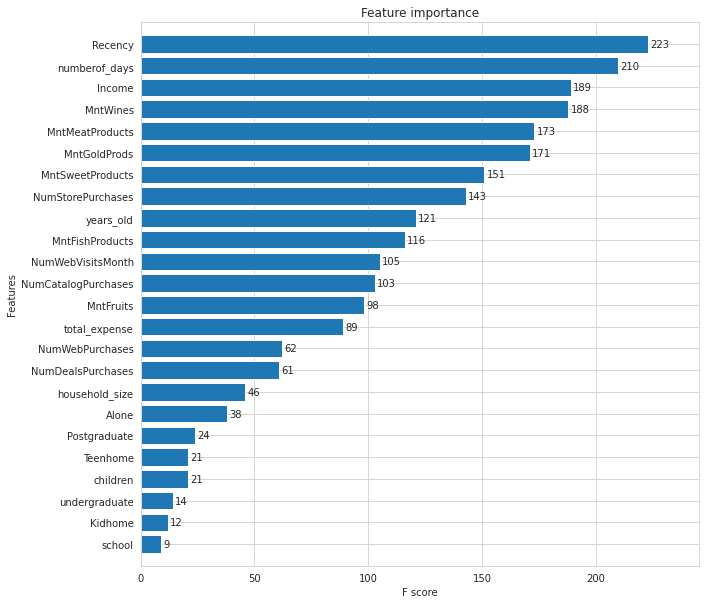

In [142]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(x_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

##Observations

The 3 important features for determining if a customer will accept the offer are Recency, number of days since the customer joined and income 